# Number of G@C collection point

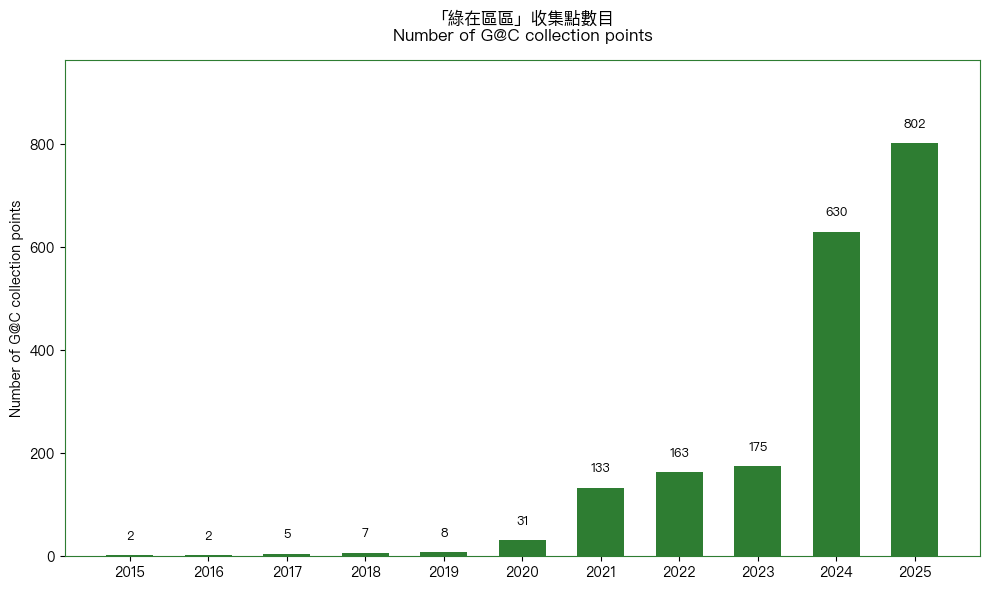

In [3]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# ---------- load data ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns by header pattern ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

num_patterns  = [r"number\s+of\s+g@c\s+collection\s+points"]
year_patterns = [r"^year$"]

num_col  = find_col(df.columns, num_patterns)
year_col = find_col(df.columns, year_patterns)

if num_col is None or year_col is None:
    raise RuntimeError("Could not find required columns (Year / Number of G@C collection points).")

# ---------- clean & align series ----------
sub = df[[year_col, num_col]].copy()

# clean number of collection points
sub[num_col] = (
    sub[num_col]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
sub[num_col] = pd.to_numeric(sub[num_col], errors="coerce")

# drop rows where the number is NaN / missing
sub = sub.dropna(subset=[num_col])

# take last 11 valid rows (the 2,2,5,7,8,31,133,163,175,630,802)
sub = sub.tail(11)

# years as strings, but strip trailing ".0" if present
years_raw = sub[year_col].astype(str).tolist()
years = [re.sub(r"\.0$", "", y) for y in years_raw]

num_vals = sub[num_col].tolist()

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot vertical bar chart (green) ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

x = range(len(years))
bar_color = "#2e7d32"  # green

# green border for axes
for spine in ax.spines.values():
    spine.set_color(bar_color)

bars = ax.bar(x, num_vals, color=bar_color, width=0.6)

# y-axis limit with headroom
valid_vals = [v for v in num_vals if pd.notna(v)]
max_val = max(valid_vals) if valid_vals else 0
ax.set_ylim(0, max_val * 1.2 + 1)

# add value labels above each bar
for xi, v in zip(x, num_vals):
    if pd.isna(v):
        continue
    ax.text(
        xi,
        v + max_val * 0.03,
        f"{int(v)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_xticks(list(x))
ax.set_xticklabels(years, rotation=0, ha="center")

ax.set_ylabel("Number of G@C collection points")

title_cn = "「綠在區區」收集點數目"
title_en = "Number of G@C collection points"
ax.set_title(title_cn + "\n" + title_en, pad=14)

plt.tight_layout()
plt.show()
